# **GIS × Python Tutorial 5.4 ~ 標準地域メッシュの作成 ~**

<br>

## **はじめに**
この記事は「GIS × Python Tutorial」の関連記事です。

前回の記事では MeshGrid の作成に関して紹介しました。今回は地域メッシュを作成していきます。


## **地域メッシュとは**
地域メッシュとは、経緯度に基づき地域を隙間なく GridMesh で覆ったものです。地域メッシュには以下の様な特徴があります。

 - ほぼ同一の大きさ及び形状の区画を単位として区分されているので，地域メッシュ相互間の事象の計量的比較が容易です。

 - 位置や区画が固定されていることから，市町村などの行政区域の境域変更や地形，地物の変化による調査区の設定変更などの影響を受けることがなく，地域事象の時系列的比較が容易です。

 - 任意の地域について，その地域内の地域メッシュのデータを合算することにより，必要な地域のデータを容易に入手できます。

 - 地域メッシュは，緯度・経度に基づき区画されたほぼ正方形の形状であることから，位置の表示が明確で簡便にできるので，距離に関連した分析，計算，比較が容易です。


地域メッシュ別に情報を表示する方法は，統計データの表示のみにとどまらず，地形，自然環境，行政地域，道路・鉄道，公共施設，文化財などの位置・範囲等を数値化して表示するなど，多くの分野で広まっています。これらの数値情報と統計データを重ね合わせて地域メッシュ別に表示あるいは分析することにより，地域メッシュ統計を更に多角的に利用することができます。 


## **地域メッシュの種類**
|    | 区画の種類         | 区分方法                                                                                                             | 経度の間隔   | 緯度の間隔   | 1辺の長さ   |
|---:|:-------------------|:---------------------------------------------------------------------------------------------------------------------|:-------------|:-------------|:------------|
|  0 | 第1次地域区画      | 全国の地域を偶数緯度及びその間隔（120分）を3等分した緯度における緯線並びに１度ごとの経線とによって分割してできる区域 | 1度          | 40分         | 約80km      |
|  1 | 第2次地域区画      | 第1次地域区画を緯線方向第2次地域区画及び経線方向に8等分してできる区域                                                | 7分30秒      | 5分          | 約10km      |
|  2 | 基準（第3次）地域メッシュ   | 第2次地域区画を緯線方向及び経線方向に8等分してできる区画                                                             | 45秒         | 30秒         | 約1km       |
|  3 | 2分の1地域メッシュ | 基準地域メッシュ（第3次地域区画）を緯線方向，経線方向に2等分してできる区域                                           | 22.5秒       | 15秒         | 約500m      |
|  4 | 4分の1地域メッシュ | 2分の1地域メッシュを緯線方向，経線方向に3等分してできる区域                                                          | 11.25秒      | 7.5秒        | 約250m      |
|  5 | 8分の1地域メッシュ | 4分の1地域メッシュを緯線方向，経線方向に2等分してできる区域                                                          | 5.625秒      | 3.75秒       | 約125m      |


今回はこの中から「基準地域メッシュ」の作成を行ってみます。
<br>

## **コード実行の準備**

### **Import**

In [8]:
from decimal import Decimal
from decimal import ROUND_FLOOR
from typing import NamedTuple

import geopandas as gpd
from matplotlib import pyplot as plt
import numpy as np
import shapely
from shapely.plotting import plot_polygon

## **最初に知るべき注意点**
---
経緯度は10進数で表しますが、小数部分の桁数が多いことは欠点です。ご存じの方もいらっしゃるかとは思いますが Pythonなどの は浮動小数点数の計算が苦手です。我々が 10進数を渡したとしてもそれを一度 2進数に変換してから計算し、また 10進数に直して返すのですが、その際に計算誤差が生じます。実際に確認してみましょう。

In [4]:
lon_min = 141.2375
lon_max = 141.9125
correct = 0.675

print(f"""
計算結果: {lon_max - lon_min}
正解    : {correct}
""")


計算結果: 0.674999999999983
正解    : 0.675



上記を見てもわかる通り、小数部での計算誤差が確認できます。通常であれば無視しても良いような場合もありますが、この地域メッシュの作成においては座標が正確である事が大切なので、この小数部の取り扱いについても注意する必要があります。

これを解決するには以下の方法があります。

 - 整数にして計算し、浮動小数点数に戻す

 - Decimal モジュールを使用する

まずは整数にする方法を見ていきましょう。今回は小数部分の桁数を 9桁とします。

In [5]:
digits = 9
coef = int('1' + '0' * digits)

print(f"""
計算結果: {(lon_max * coef - lon_min * coef) / coef}
正解    : {correct}
""")


計算結果: 0.675
正解    : 0.675



計算結果が一致しました。これでも問題ないかもしれませんが、Python的には 10進浮動小数点算術の為の Python 標準モジュールである Decimal モジュールを使用した方が綺麗に見えるかもしれません。

In [6]:
lon_min = Decimal(str(lon_min))
lon_max = Decimal(str(lon_max))

print(f"""
計算結果: {lon_max - lon_min}
正解    : {correct}
""")


計算結果: 0.6750
正解    : 0.675



## **度分秒から10進経緯度への変換**
---
「地域メッシュの種類」表で確認した様に、各メッシュのサイズは度分秒で定義されています。このままでは計算しづらいので、度分秒から10進経緯度に変換する関数を作成します。また今後の関数で出力される Float型の値は`decimal.Deciaml`として返したいのでデコレーターを作成して管理しましょう。

In [12]:
class Pitch(NamedTuple):
    lon: Decimal
    lat: Decimal


def set_decimal(func):
    def wrapper(*args):
        new_args = []
        for arg in args:
            if type(arg) == float:
                new_args.append(Decimal(str(arg)))
            else:
                new_args.append(arg)
        result = func(*new_args)
        if type(result) == float:
            return Decimal(str(result))
        return result
    return wrapper


@set_decimal
def dms_to_lonlat(d, m, s):
    return (d + m / 60 + s / 3600)



tertiary_pitch = Pitch(
    lon=dms_to_lonlat(0, 0, 45),
    lat=dms_to_lonlat(0, 0, 30)
)
print(f"""
<<< 基準地域メッシュの経緯度間隔 >>>
lon: {tertiary_pitch.lon}
lat: {tertiary_pitch.lat}
""")


<<< 基準地域メッシュの経緯度間隔 >>>
lon: 0.0125
lat: 0.008333333333333333



## **GridMeshの範囲を計算**

前回の記事で作成したGridMeshは渡したデータのXの最小値とYの最大値からスタートした範囲を計算しましたが、基準地域メッシュは決まった位置がある為、「どのメッシュ範囲にデータ範囲が収まるか」を計算する必要があります。

メッシュに合わせた最小の座標を計算するには、与えられた座標から各メッシュ間隔で除算して得た剰余を引くことで求めます。

メッシュに合わせた最大の座標を計算するには、与えられた座標から各メッシュ間隔で除算して得た剰余を引き、その後メッシュ間隔を加えることで求めます。

In [13]:
@set_decimal
def min_cds(lonlat, pitch):
    """最小の座標を計算する"""
    return lonlat - lonlat % pitch

@set_decimal
def max_cds(lonlat, pitch):
    """最大の座標を計算する"""
    return lonlat - lonlat % pitch + pitch


# 今回メッシュ作成の材料にする座標
x_min = 140.38589
y_min = 40.53722
x_max = 140.55906
y_max = 40.67484

tertiary_lon_min = min_cds(x_min, tertiary_pitch.lon)
tertiary_lat_min = min_cds(y_min, tertiary_pitch.lat)
tertiary_lon_max = max_cds(x_max, tertiary_pitch.lon)
tertiary_lat_max = max_cds(y_max, tertiary_pitch.lat)

print(f"""
data lon min: {x_min} -> result lon min: {tertiary_lon_min}
remainder: {tertiary_lon_min % tertiary_pitch.lon}

data lat min: {y_min} -> result lat min: {tertiary_lat_min}
remainder: {tertiary_lat_min % tertiary_pitch.lat}

data lon max: {x_max} -> result lon min: {tertiary_lon_max}
remainder: {tertiary_lon_min % tertiary_pitch.lon}

data lat max: {y_max} -> result lat min: {tertiary_lat_max}
remainder: {tertiary_lat_max % tertiary_pitch.lat}
""")


data lon min: 140.38589 -> result lon min: 140.37500
remainder: 0.00000

data lat min: 40.53722 -> result lat min: 40.533333333333331712
remainder: 0E-18

data lon max: 140.55906 -> result lon min: 140.56250
remainder: 0.00000

data lat max: 40.67484 -> result lat min: 40.674999999999998373
remainder: 0E-18



全て正しく計算されており、経緯度の間隔で割り切れる座標である事が確認出来ました。
<br>

## **GridMeshの作成**

ここまでで各メッシュ間隔とメッシュを投影する範囲の計算を行ってきました。次は前回の記事と同様に範囲内のMeshGridの座標を計算していきます。本来であれば地域メッシュのメッシュコードは左下から始まるのですが、Geometryの生成には関係ないので、今回も左上から生成される様にします。

In [14]:
class Corners(NamedTuple):
    upper_left_corner: np.ndarray[float]
    upper_right_corner: np.ndarray[float]
    lower_left_corner: np.ndarray[float]
    lower_right_corner: np.ndarray[float]


def corners(coords_2d):
    # 左上の座標を格納した1次元配列
    ul = coords_2d[: - 1, : -1].flatten()
    # 右上の座標を格納した1次元配列
    ur = coords_2d[: -1, 1: ].flatten()
    # 左下の座標を格納した1次元配列
    ll = coords_2d[1: , : -1].flatten()
    # 右下の座標を格納した1次元配列
    lr = coords_2d[1: , 1:].flatten()
    return Corners(ul, ur, ll, lr)


def decimal_to_float(value, digits=9):
    exp = Decimal('1.' + '0' * digits)
    value = (
        round(value, digits + 1)
        .quantize(exp, rounding=ROUND_FLOOR)
    )
    return float(value)


def generate_grid(x_2d: np.ndarray, y_2d: np.ndarray):
    X = corners(x_2d)
    Y = corners(y_2d)
    polys = []
    X_min = X.upper_left_corner
    X_max = X.upper_right_corner
    Y_min = Y.lower_left_corner
    Y_max = Y.upper_left_corner
    for coords in zip(X_min, Y_min, X_max, Y_max):
        poly = shapely.box(*[decimal_to_float(c) for c in coords])
        polys.append(poly)
    return polys


xs = np.arange(
    tertiary_lon_min, 
    tertiary_lon_max + tertiary_pitch.lon, 
    tertiary_pitch.lon
)
ys = np.arange(
    tertiary_lat_min, 
    tertiary_lat_max + tertiary_pitch.lat, 
    tertiary_pitch.lat
)[::-1]

x_2d, y_2d = np.meshgrid(xs, ys)
meshgrid = generate_grid(x_2d, y_2d)


可視化して Polygon 同士が接しているのかを検証してみましょう。

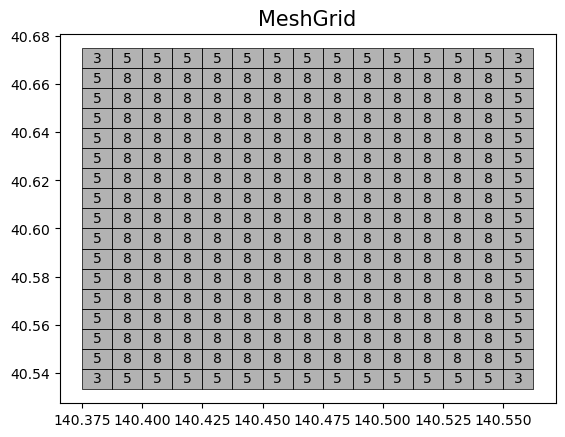

In [15]:
kwargs = dict(
    horizontalalignment='center',
    verticalalignment='center'
)

geoms = gpd.GeoSeries(meshgrid)

fig, ax = plt.subplots()
for i, poly in enumerate(meshgrid):
    plot_polygon(poly, ax, False, 'black', lw=0.5)
    pt = poly.centroid
    # 点または辺を共有しているPolygonをカウント
    length = geoms[geoms.touches(poly)].shape[0]
    ax.text(pt.x, pt.y, length, **kwargs)
ax.set_title('MeshGrid', fontsize=15)
ax.axis('equal');

## **参考**

[地域メッシュ統計の概要](https://www.stat.go.jp/data/mesh/gaiyou.html)

[decimal](https://docs.python.org/ja/3/library/decimal.html#decimal.Decimal.quantize)